# CDnow网站的用户购买明细分析

数据集来源于CDnow网站的用户购买行为，数据集一共包含四个字段：user_id，购买日期，购买数量和购买金额。属于非常典型的消费行为数据集。

## 1. 数据加载与描述性统计

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
plt.style.use('ggplot')

In [2]:
columns=['user_id','order_dt','order_products','order_amount']#生成列名
df=pd.read_csv('CDNOW.txt',names=columns,sep='\s+')#载入数据

加载包和数据，文件是txt，用read_csv方法打开，因为原始数据不包含表头，所以需要赋予。字符串是空格分割，用\s+表示匹配任意空白符。

In [3]:
df.head()

,user_id,order_dt,order_products,order_amount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


观察数据，order_dt表示时间，但现在它只是年月日组合的一串数字，没有时间含义。购买金额是小数。值得注意的是，一个用户在一天内可能购买多次，用户ID为2的用户就在1月12日买了两次。

In [4]:
df.describe()

,user_id,order_dt,order_products,order_amount
count,69659.000000,6.965900e+04,69659.000000,69659.000000
mean,11470.854592,1.997228e+07,2.410040,35.893648
std,6819.904848,3.837735e+03,2.333924,36.281942
min,1.000000,1.997010e+07,1.000000,0.000000
25%,5506.000000,1.997022e+07,1.000000,14.490000
50%,11410.000000,1.997042e+07,2.000000,25.980000
75%,17273.000000,1.997111e+07,3.000000,43.700000
max,23570.000000,1.998063e+07,99.000000,1286.010000


用户平均每笔订单购买2.4个商品，标准差在2.3，稍稍具有波动性。中位数在2个商品，75分位数在3个商品，说明绝大部分订单的购买量都不多。最大值在99个，数字比较高。购买金额的情况差不多，大部分订单都集中在小额。

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
user_id           69659 non-null int64
order_dt          69659 non-null int64
order_products    69659 non-null int64
order_amount      69659 non-null float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


没有空值，很干净的数据。

## 2. 时间列转换

In [6]:
df['order_date'] = pd.to_datetime(df.order_dt, format = '%Y%m%d')
#pd.to_datetime可以将特定的字符串或者数字转换成时间格式，其中的format参数用于匹配。例如19970101，%Y匹配前四位数字1997，如果y小写只匹配两位数字97，%m匹配01，%d匹配01
df['month'] = df.order_date.astype('datetime64[M]')
#astype也可以将时间格式进行转换，比如[M]转化成月份。我们将月份作为消费行为的主要事件窗口，选择哪种时间窗口取决于消费频率。

In [7]:
df.head()

,user_id,order_dt,order_products,order_amount,order_date,month
0,1,19970101,1,11.77,1997-01-01,1997-01-01
1,2,19970112,1,12.00,1997-01-12,1997-01-01
2,2,19970112,5,77.00,1997-01-12,1997-01-01
3,3,19970102,2,20.76,1997-01-02,1997-01-01
4,3,19970330,2,20.76,1997-03-30,1997-03-01


月份依旧显示日，不过都变为月初的形式，后边可以以月为窗口对其进行聚合。

## 3.数据探索

上述消费行为数据维度是每笔订单，我们将其转换为每个用户。用groupby方法，等同于excel的透视表以及sql的group by.

In [8]:
user_grouped = df.groupby('user_id').sum()
user_grouped.head()

,order_dt,order_products,order_amount
user_id,,,
1,19970101,1,11.77
2,39940224,6,89.00
3,119833602,16,156.46
4,79882233,7,100.50
5,219686137,29,385.61


In [9]:
user_grouped.describe()

,order_dt,order_products,order_amount
count,2.357000e+04,23570.000000,23570.000000
mean,5.902627e+07,7.122656,106.080426
std,9.460684e+07,16.983531,240.925195
min,1.997010e+07,1.000000,0.000000
25%,1.997021e+07,1.000000,19.970000
50%,1.997032e+07,3.000000,43.395000
75%,5.992125e+07,7.000000,106.475000
max,4.334408e+09,1033.000000,13990.930000


由上图知，每个用户平均购买7张CD，最多购买了1033张。用户平均消费金额106元，然而中位数才只有43元，因此肯定存在少部分的高额消费用户。

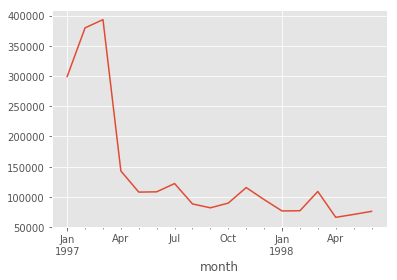

In [10]:
#这里以月为窗口对其透视
df.groupby('month').order_amount.sum().plot()

发现早期消费金额很高，后边逐渐下降。为何会出现这种情况，下面探索是否有离群点。

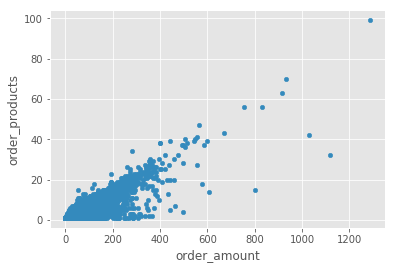

In [11]:
#绘制每笔订单的散点图
df.plot.scatter(x = 'order_amount', y = 'order_products')

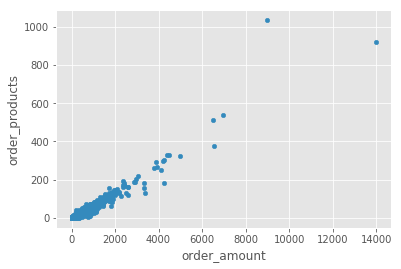

In [12]:
#绘制用户的订单散点图。
df.groupby('user_id').sum().plot.scatter(x = 'order_amount', y = 'order_products')


都未发现明显异常点，订单均价在10元左右。

分析单个用户的消费行为

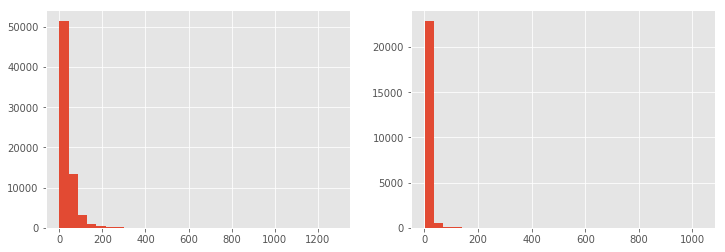

In [14]:
plt.figure(figsize = (12,4))
plt.subplot(121)
df.order_amount.hist(bins = 30)
plt.subplot(122)
df.groupby('user_id').order_products.sum().hist(bins = 30)

从直方图上看到，大部分顾客的消费能力一般，高消费用户在图中几乎看不到，这也符合消费行业的一般规律。

观察消费的时间节点;
用户初次消费月份;
主要集中在前三个月;


In [15]:
df.groupby('user_id').month.min().value_counts()

1997-02-01    8476
1997-01-01    7846
1997-03-01    7248
Name: month, dtype: int64

#用户最后消费月份
#同样主要集中在前三个月，后边也有用户消费，但数量逐渐减少

In [16]:
df.groupby('user_id').month.max().value_counts()

1997-02-01    4912
1997-03-01    4478
1997-01-01    4192
1998-06-01    1506
1998-05-01    1042
1998-03-01     993
1998-04-01     769
1997-04-01     677
1997-12-01     620
1997-11-01     609
1998-02-01     550
1998-01-01     514
1997-06-01     499
1997-07-01     493
1997-05-01     480
1997-10-01     455
1997-09-01     397
1997-08-01     384
Name: month, dtype: int64

## 4. 分析复购率和回购率

In [17]:
#将数据进行透视
pivoted_counts = df.pivot_table(index = 'user_id', columns = 'month',
                               values = 'order_dt', aggfunc = 'count').fillna(0)
columns_month = df.month.sort_values().astype('str').unique()
pivoted_counts.columns = columns_month
pivoted_counts.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


函数说明： pandas中数据透视有专门的透视函数：pivot_table，在pivot_table参数中，index是设置数据透视后的索引，columns是设置透视后的列，values是按照哪个值进行计算，aggfunc是按照哪个函数进行计算，这里用values = ‘order_dt’, aggfunc = 'count’就是统计order_dt出现的次数，即订单数。某些用户在某月没有消费，会用NaN表示，这里用fillnan(0)，将其换为0。
数据透视月份是月份是1997-01-01 00:00:00，将其转化为标准格式，columns_month = df.month.sort_values().astype(‘str’).unique()

#复购率
#复购率指在某时间窗口内消费两次及以上用户所占的比例
#这里时间窗口为一个月
#消费两次及以上记为1，消费一次计0，没有消费记为NaN。

In [18]:
pivoted_counts_transf = pivoted_counts.applymap(lambda x: 1 if x>1 else np.NaN if x==0 else 0)
pivoted_counts_transf.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


#applymap函数是针对DataFrame里的每个数据，apply函数仅针对DataFrame中的一维向量进行运算。
#用lambda进行判断，因为这里涉及了多个结果，所以要两个if else，lambda没有elif用法。

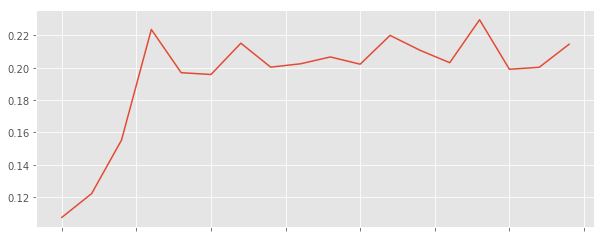

In [19]:
(pivoted_counts_transf.sum()/pivoted_counts_transf.count()).plot(figsize = (10,4))


#用sum（）和count（）函数或者单独的mean（）函数即可计算复购率。它们均能忽略NaN，NaN至没有消费的用户，自燃不必统计进去。但count()会把0统计进去，0指仅消费了一次的用户。
#由上图可以看出，在再起，由于新用户的大量加入，早期新客的复购率并不高，但随着时间的推移，出现比较多忠诚的老顾客，复购率上升，维持在20%左右。


#回购率
#回购率指在某一个时间窗口内消费，在下一个时间窗口任然消费的顾客占比
#回购率涉及到两个相邻时间窗口的对比，计算稍显复杂。

In [20]:
pivoted_amount = df.pivot_table(index = 'user_id', columns = 'month',
                               values = 'order_amount', aggfunc = 'mean').fillna(0)
columns_month = df.month.sort_values().astype('str').unique()
pivoted_amount.columns = columns_month
pivoted_amount.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,11.77,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.00,0.0
2,44.50,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.00,0.0
3,20.76,0.0,20.76,19.54,0.00,0.00,0.00,0.00,0.00,0.0,39.205,0.000,0.00,0.0,0.0,0.0,16.99,0.0
4,29.53,0.0,0.00,0.00,0.00,0.00,0.00,14.96,0.00,0.0,0.000,26.480,0.00,0.0,0.0,0.0,0.00,0.0
5,21.65,38.9,0.00,45.55,38.71,26.14,28.14,0.00,40.47,0.0,0.000,43.465,37.47,0.0,0.0,0.0,0.00,0.0


#将消费金额进行了数据透视，这里简单使用了某顾客一月内消费的平均值。

#再次使用applymap和lambda，某月内有消费记录记为1，没有则为0.

In [21]:
pivoted_purchase = pivoted_amount.applymap(lambda x:1 if x> 0 else 0)
pivoted_purchase.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0


In [22]:
def purchase_return(data):
    status = []
    for i in range(17):
        if data[i] == 1:
            if data[i+1] == 1:
                status.append(1)
            if data[i+1] == 0:
                status.append(0)
        else:
            status.append(np.NaN)
    status.append(np.NaN)
    return status
from pandas import DataFrame
pivoted_purchase_return = pivoted_purchase.apply(purchase_return, axis = 1)
#此时输出为Series，需要将其转化为DataFrame类型，相应设置index和columns
columns_month = df.month.sort_values().astype('str').unique()
user_id = pivoted_purchase.index
pivoted_purchase_return1 = pd.DataFrame(list(pivoted_purchase_return),columns = columns_month, index = user_id)
#Series转化为Dataframe的方法：先转化为list类型，再转化为DataFrame，期间可传入columns
pivoted_purchase_return1.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


上面函数if的主要逻辑为，如果用户本月有消费，且下月有消费，记为1，下月无消费，记为0；如果用户本月没有消费，记为NaN。
用apply函数且axis=1，应用在所有行上。

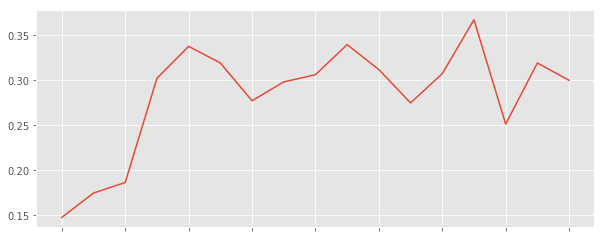

In [23]:
pivoted_purchase_return1.mean().plot(figsize = (10,4))

#可知，用户的回购率约为30%，大于复购率20%。
#综合回购率和复购率可知，新客质量整体低于老客，老客忠诚度表现较好，这是CDNow网站的用户消费特征。

## 5.用户分层 

按照用户的消费行为，将其分为4个维度：新用户、活跃用户、不活跃用户、回流用户。
新用户指第一次消费。活跃用户即老客，指在某一个时间窗口内有过消费。不活跃用户指在某一个时间窗口内没有消费过的老客。回流用户指在上一个窗口内没有消费，在当前窗口内有消费。以上窗口按月计。

例如，某一个用户，在1月份首次消费即是新用户；他在2月份又消费，则是活跃用户；3月份不消费，属于不活跃用户；4月份消费，此时是回流用户，5月份又消费，属于活跃用户。
用户分层涉及到比较复杂的逻辑判断。

In [24]:
def active_ststus(data):
    status = []
    for i in range(18):
        #若本月没有消费
        if data[i] == 0:
            if len(status) > 0:
                if status[i-1] == 'unreg':
                    status.append('unreg')
                else:
                    status.append('unactive')
            else:
                status.append('unreg')
        #若本月有消费
        else:
            if len(status) == 0:
                status.append('new')
            else:
                if status[i-1] == 'unactive':
                    status.append('return')
                elif status[i-1] == 'unreg':
                    status.append('new')
                else:
                    status.append('active')
    return status
pivoted_purchase_status = pivoted_purchase.apply(lambda x: active_ststus(x), axis = 1)
#此时输出为Series，需要将其转化为DataFrame类型，相应设置index和columns
columns_month = df.month.sort_values().astype('str').unique()
user_id = pivoted_purchase.index
pivoted_purchase_status1 = pd.DataFrame(list(pivoted_purchase_status),columns = columns_month, index = user_id)
pivoted_purchase_status1.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
2,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
3,new,unactive,return,active,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,return,unactive
4,new,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,unactive
5,new,active,unactive,return,active,active,active,unactive,return,unactive,unactive,return,active,unactive,unactive,unactive,unactive,unactive


if逻辑判断部分比较复杂，主要分为两部分：如果本月没有消费，还要额外判断他是不是新客，如果一直不是新客，则延续之前的状态，设置为unreg。
如果本月有消费，则需判断是不是第一次消费以及上一个时间窗口的消费状态。

用户每个月的分层状态以及变化已经被计算出来。

In [25]:
purchase_status1_counts = pivoted_purchase_status1.replace('unreg', np.NaN).apply(pd.value_counts) #此时apply是在列上执行运算
#把unreg状态排除掉，他是未来作为新客，只是一个暂时状态。然后计算不同分层每月的统计量
purchase_status1_counts

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
active,NaN,1155.0,1680,1773.0,852.0,747.0,746.0,604.0,528.0,532.0,624,632.0,512.0,472.0,569.0,517.0,458.0,446.0
new,7814.0,8455.0,7231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
return,NaN,NaN,595,1049.0,1362.0,1592.0,1434.0,1168.0,1211.0,1307.0,1402,1232.0,1025.0,1079.0,1489.0,919.0,1030.0,1060.0
unactive,NaN,6659.0,13994,20678.0,21286.0,21161.0,21320.0,21728.0,21761.0,21661.0,21474,21638.0,21965.0,21951.0,21444.0,22066.0,22014.0,21996.0


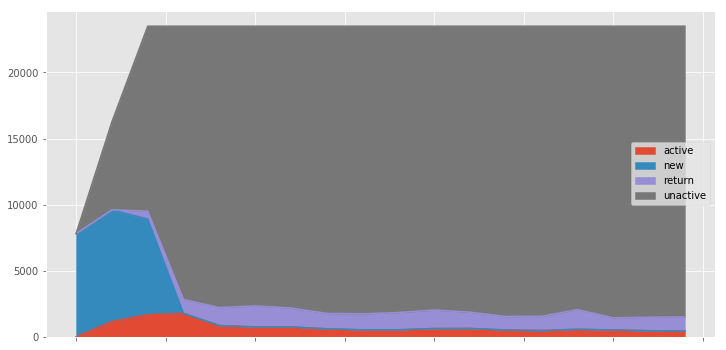

In [26]:
purchase_status1_counts.fillna(0).T.plot.area(figsize = (12,6))

只看红色和紫色活跃用户和回流用户两个分层，他们的和就是消费用户占比。3月份之后，总量不再变化，说明后期没有新客。

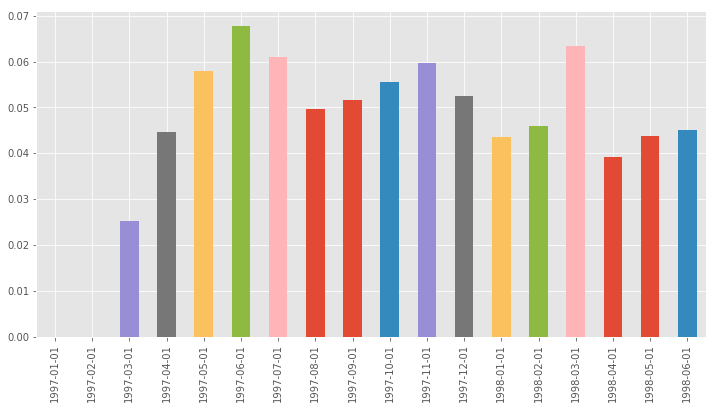

In [27]:
return_rate = purchase_status1_counts.apply(lambda x: x/x.sum())
return_rate.loc['return'].plot.bar(figsize = (12,6)) #每个月回流用户的占比

回流用户占比为5%-8%之间，有下降趋势，回流用户占比，指在总用户中的占比。

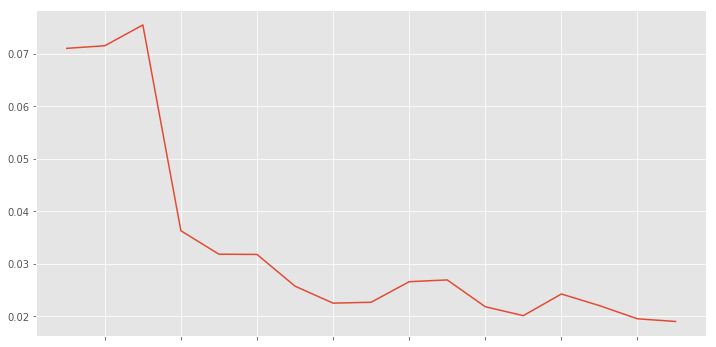

In [28]:
return_rate.loc['active'].plot(figsize = (12,6)) #每月活跃用户的占比

#活跃用户下降趋势更明显，后期占比为2%左右。活跃用户为连续消费用户，质量在一定程度上高于回流用户。

#结合回流用户和活跃用户，后期消费中60%是回流用户，40%是活跃用户，整体质量尚可，对于这两个分层依旧有改进空间，可以继续细化数据。

## 6.探究高质量用户

In [29]:
user_amount = df.groupby('user_id').order_amount.sum().sort_values().reset_index()
user_amount['amount_cumsum'] = user_amount.order_amount.cumsum()
user_amount.tail()

,user_id,order_amount,amount_cumsum
23565,7931,6497.18,2463822.60
23566,19339,6552.70,2470375.30
23567,7983,6973.07,2477348.37
23568,14048,8976.33,2486324.70
23569,7592,13990.93,2500315.63


按照消费金额排序，cumsum是累加函数，逐行计算累积的金额，最后的2500315便是总消费金额

In [30]:
amount_total = user_amount.amount_cumsum.max()
user_amount['prop'] = user_amount.apply(lambda x: x.amount_cumsum/amount_total, axis = 1)
user_amount.tail()

,user_id,order_amount,amount_cumsum,prop
23565,7931,6497.18,2463822.60,0.985405
23566,19339,6552.70,2470375.30,0.988025
23567,7983,6973.07,2477348.37,0.990814
23568,14048,8976.33,2486324.70,0.994404
23569,7592,13990.93,2500315.63,1.000000


转换成百分比

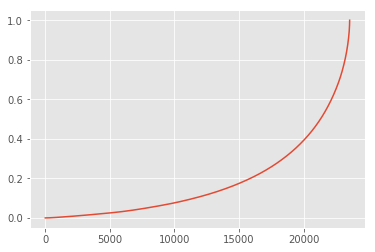

In [31]:
user_amount.prop.plot()

图中可以明显的看出，前20000个用户贡献了40%的消费，后4000位用户贡献了60%的消费金额。确实呈现二八倾向。

同理，观察订单数量这个维度：

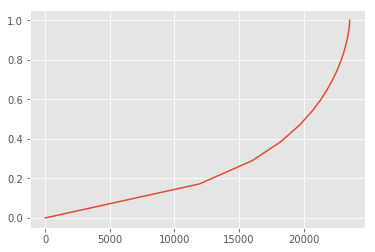

In [32]:
user_counts = df.groupby('user_id').order_dt.count().sort_values().reset_index()
user_counts['counts_cumsum'] = user_counts.order_dt.cumsum()
counts_total = user_counts.counts_cumsum.max()
user_counts['prop'] = user_counts.apply(lambda x: x.counts_cumsum/counts_total, axis = 1)
user_counts.prop.plot()

前20000个用户贡献了45%的销量。消费领域，狠抓高质量用户才是王道。

## 7. 计算用户生命周期

第一次消费至最后一次消费时间之差为用户的生命周期

In [33]:
user_purchase = df[['user_id','order_products','order_amount','order_date']]
order_date_min = user_purchase.groupby('user_id').order_date.min()
order_date_max = user_purchase.groupby('user_id').order_date.max()
(order_date_max-order_date_min).head(10)

user_id
1      0 days
2      0 days
3    511 days
4    345 days
5    367 days
6      0 days
7    445 days
8    452 days
9    523 days
10     0 days
Name: order_date, dtype: timedelta64[ns]

In [34]:
(order_date_max-order_date_min).mean()

Timedelta('134 days 20:55:36.987696')

#用户生命周期平均为134天。
#这里数据类型是timedelta时间，无法直接做直方图，需要先换算成数值。换算方法直接除以timedelat函数即可。这里的np.timedelta64(1, ‘D’)，D表示天，1表示1天，作为单位使用的。因为max-min已经表示为天了，两者相除就是周期的天数

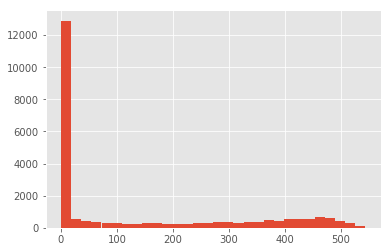

In [35]:
((order_date_max-order_date_min)/np.timedelta64(1,'D')).hist(bins=30)

可见大部分用户只消费了一次，用户生命周期都集中在了0天，这并不是我们想要的。因此将只消费一次的用户删除掉，来计算消费两次以上顾客的生命周期。

In [36]:
life_time = (order_date_max-order_date_min).reset_index() #转换为dataframe类型
life_time.head()

,user_id,order_date
0,1,0 days
1,2,0 days
2,3,511 days
3,4,345 days
4,5,367 days


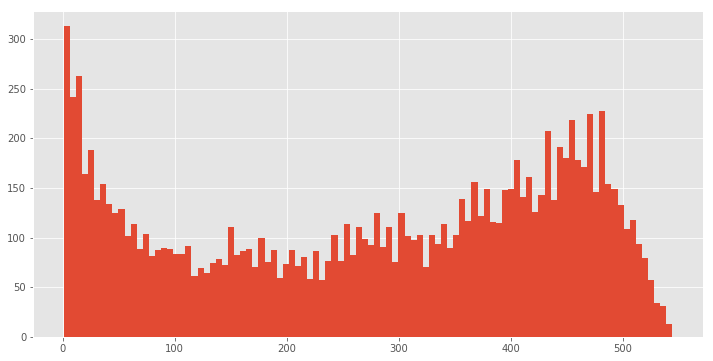

In [37]:
life_time['life_time'] = life_time.order_date/np.timedelta64(1,'D')
life_time[life_time.life_time>0].life_time.hist(bins = 100, figsize = (12,6))

虽然仍有不少用户生命周期集中在0天，但比第一张图好很多了，呈现双峰趋势图。部分质量差的用户虽然消费了两次，但仍旧无法持续，在用户首次消费30天内应该尽量引导。少部分用户集中在50天～300天，属于普通型的生命周期，高质量用户的生命周期，集中在400天以后，这已经属于忠诚用户了。

In [38]:
life_time[life_time.life_time>0].life_time.mean()

276.0448072247308

消费两次以上用户的生命周期是276天。远高于总体的134天

## 8.计算留存率

留存率是消费领域的经典应用。指用户第一次消费后，有多少比率进行第二次消费。和回流率区别是留存率倾向于计算第一次消费，并有多个时间窗口。

In [39]:
user_purchase_retention = pd.merge(left = user_purchase, right = order_date_min.reset_index(),
                                   how = 'inner', on = 'user_id',
                                   suffixes = ('', '_min')
                                  )
user_purchase_retention.head()


,user_id,order_products,order_amount,order_date,order_date_min
0,1,1,11.77,1997-01-01,1997-01-01
1,2,1,12.00,1997-01-12,1997-01-12
2,2,5,77.00,1997-01-12,1997-01-12
3,3,2,20.76,1997-01-02,1997-01-02
4,3,2,20.76,1997-03-30,1997-01-02


这里的merge函数和sql中的join作用差不多，用来将两个DataFrame合并。这里选用inner join方法合并，以user_id为标准。suffxes参数是如果合并的内容中有重名column，加上后缀。

In [40]:
user_purchase_retention['order_date_diff'] = user_purchase_retention.order_date-user_purchase_retention.order_date_min
#将日期转化为时间
user_purchase_retention['date_diff'] = user_purchase_retention.order_date_diff.apply(lambda x: x/np.timedelta64(1,'D')) #日期转换为时间
user_purchase_retention.head()

,user_id,order_products,order_amount,order_date,order_date_min,order_date_diff,date_diff
0,1,1,11.77,1997-01-01,1997-01-01,0 days,0.0
1,2,1,12.00,1997-01-12,1997-01-12,0 days,0.0
2,2,5,77.00,1997-01-12,1997-01-12,0 days,0.0
3,3,2,20.76,1997-01-02,1997-01-02,0 days,0.0
4,3,2,20.76,1997-03-30,1997-01-02,87 days,87.0


In [41]:
bin = [0,3,7,15,30,60,90,180,365]
user_purchase_retention['date_diff_bin'] = pd.cut(user_purchase_retention.date_diff, bins = bin)
user_purchase_retention.head(10)

,user_id,order_products,order_amount,order_date,order_date_min,order_date_diff,date_diff,date_diff_bin
0,1,1,11.77,1997-01-01,1997-01-01,0 days,0.0,NaN
1,2,1,12.00,1997-01-12,1997-01-12,0 days,0.0,NaN
2,2,5,77.00,1997-01-12,1997-01-12,0 days,0.0,NaN
3,3,2,20.76,1997-01-02,1997-01-02,0 days,0.0,NaN
4,3,2,20.76,1997-03-30,1997-01-02,87 days,87.0,"(60, 90]"
5,3,2,19.54,1997-04-02,1997-01-02,90 days,90.0,"(60, 90]"
6,3,5,57.45,1997-11-15,1997-01-02,317 days,317.0,"(180, 365]"
7,3,4,20.96,1997-11-25,1997-01-02,327 days,327.0,"(180, 365]"
8,3,1,16.99,1998-05-28,1997-01-02,511 days,511.0,NaN
9,4,2,29.33,1997-01-01,1997-01-01,0 days,0.0,NaN


利用cut函数将数据进行分箱。这里date_diff=0并没有被划分入0～3天，因为计算的是留存率，如果用户仅消费了一次，留存率应该是0。另外用户一天内多次消费，但以后没有消费，也算作留存率0.
然后进行数据透视：

In [42]:
pivoted_retention = user_purchase_retention.pivot_table(index = 'user_id', columns = 'date_diff_bin',
                                                       values = 'order_amount', aggfunc = sum, dropna = False)
pivoted_retention.head()

date_diff_bin,"(0, 3]","(3, 7]","(7, 15]","(15, 30]","(30, 60]","(60, 90]","(90, 180]","(180, 365]"
user_id,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,40.3,NaN,78.41
4,NaN,NaN,NaN,29.73,NaN,NaN,NaN,41.44
5,NaN,NaN,13.97,NaN,38.9,NaN,110.4,155.54


用pivot_table数据透视，获得的结果是用户在第一次消费之后，在后续各时间段内的消费总额

In [43]:
pivoted_retention.mean()

date_diff_bin
(0, 3]        35.905798
(3, 7]        36.385121
(7, 15]       42.669895
(15, 30]      45.964649
(30, 60]      50.215070
(60, 90]      48.975277
(90, 180]     67.223297
(180, 365]    91.960059
dtype: float64

#计算了第一次消费过后，后续个时间段的消费平均值，虽然后面的时间段消费金额更高，但是其时间段更广，因此第一次消费后的0-3天内有可能消费更高。
#但仍然要看具体的数字，看有多少用户比例在初次购买后0-3天内再次消费：

In [44]:
pivoted_retention_trans = pivoted_retention.fillna(0).applymap(lambda x: 1 if x>0 else 0)
pivoted_retention_trans.head()

date_diff_bin,"(0, 3]","(3, 7]","(7, 15]","(15, 30]","(30, 60]","(60, 90]","(90, 180]","(180, 365]"
user_id,,,,,,,,
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1
4,0,0,0,1,0,0,0,1
5,0,0,1,0,1,0,1,1


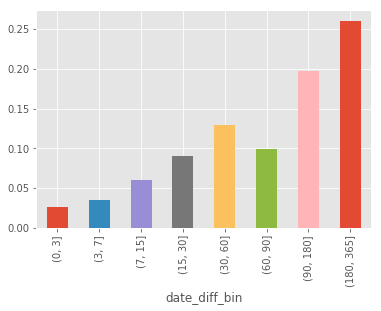

In [45]:
pivoted_retention_trans.mean().plot.bar()

可见0-3天内再次消费的比例只有只有2.5%，3-7天之内的消费比例只有3%。说明CD购买并不是高频消费行为。时间范围放宽之后，数字好看了不少，有20%的用户在3个月到半年内再次购买，25%的用户在半年到一年内再次购买。因此，从运营角度讲，既要培养新用户，又要注重培养用户忠诚度，放长线钓大鱼。

## 9.计算用户平均消费间隔

为了找准用户的购买规律，在合适的时间节点做适当的营销活动，我们需要计算平均消费间隔。

In [46]:
#计算用户的消费间隔
def diff(group):
    d = group.date_diff - group.date_diff.shift(-1)
    #shift(-1)是向下便宜一个位置；shift()是向上偏移一个位置；加参数axis=1则是左右偏移
    return d
last_diff = user_purchase_retention.groupby('user_id').apply(diff)
last_diff.head(10).reset_index()

,user_id,level_1,date_diff
0,1,0,NaN
1,2,1,0.0
2,2,2,NaN
3,3,3,-87.0
4,3,4,-3.0
5,3,5,-227.0
6,3,6,-10.0
7,3,7,-184.0
8,3,8,NaN
9,4,9,-17.0


In [47]:
last_diff.mean()

-68.97376814424265

用mean函数即可求出用户的平均消费间隔时间是68天。想要召回用户，在60天左右的消费间隔是比较好的。

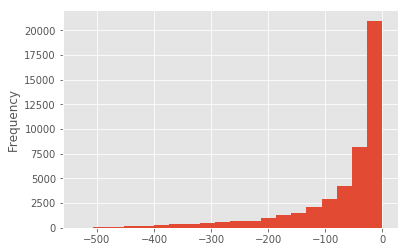

In [48]:
last_diff.plot.hist(bins=20)

看一下直方图，典型的长尾分布，大部分用户的消费间隔确实比较短。不妨将时间召回点设为消费后立即赠送优惠券，消费后10天询问用户CD怎么样，消费后30天提醒优惠券到期，消费后60天短信推送。这便是数据的应用了。